In [1]:
!pip install transformers 
!pip install Datasets 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 53.5 MB/s 
     |████████████████████████████████| 6.6 MB 41.4 MB/s 
     |████████████████████████████████| 101 kB 9.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 5.0 MB/s 
     |████████████████████████████████| 141 kB 66.0 MB/s 
     |████████████████████████████████| 115 kB 67.1 MB/s 
     |████████████████████████████████| 212 kB 65.9 MB/s 
     |████████████████████████████████| 127 kB 59.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully un

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
import torch 
from datasets import Dataset 
import transformers 
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments, BertModel

In [3]:
torch.cuda.is_available() 

True

In [4]:
df = pd.read_csv("sample.csv")
df.head() 

,Industry,CompName,year,filename,sentence_id,team,day,sentence,Label
0,Energy,CHEVRON CORP,2002,CHEVRON CORP_2002.txt,8,1,1,Product Stewardship Manage potential risks of ...,PL
1,Energy,CHEVRON CORP,2002,CHEVRON CORP_2002.txt,10,1,1,CNL and UNDP will develop a coordinated master...,CR
2,Energy,CHEVRON CORP,2003,CHEVRON CORP_2003.txt,30,1,1,ChevronTexaco continues to advocate for consis...,CC
3,Energy,CHEVRON CORP,2004,CHEVRON CORP_2004.txt,38,1,1,"Maturing oil fields, more technically challeng...",NC
4,Energy,CHEVRON CORP,2004,CHEVRON CORP_2004.txt,41,1,1,We found that units in which employees rated t...,HC


In [5]:
df = df.drop(["Industry", "CompName", "year", "filename", "sentence_id", 
              "team", "day"], axis=1)
df.columns

Index(['sentence', 'Label'], dtype='object')

In [6]:
df = df.rename(columns={"Label": "label"})
df.columns

Index(['sentence', 'label'], dtype='object')

In [9]:
df.isnull().any() 

sentence    False
label       False
dtype: bool

In [10]:
encoder = LabelEncoder() 
df['label'] = encoder.fit_transform(df['label'])
df['label'].head() 

0    7
1    3
2    1
3    6
4    4
Name: label, dtype: int64

In [13]:
classes = len(df['label'].unique())
print(classes) 

9


In [14]:
df_train, df_test, = train_test_split(df, stratify=df['label'], test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train, stratify=df_train['label'],test_size=0.1, random_state=42)
print(df_train.shape, df_test.shape, df_val.shape)

(3645, 2) (450, 2) (405, 2)


# Bert Training

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=classes)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [16]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [17]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels)}

args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
)

trainer = Trainer(
        model=model,                         
        args=args,                 
        train_dataset=dataset_train,         
        eval_dataset=dataset_val,           
        compute_metrics=compute_metrics
)

trainer.train()   

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3645
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 570


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.959052,0.777778
2,No log,0.509121,0.871605
3,No log,0.448074,0.861728
4,No log,0.396296,0.874074
5,0.663900,0.391294,0.874074


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

TrainOutput(global_step=570, training_loss=0.5992392339204488, metrics={'train_runtime': 437.1268, 'train_samples_per_second': 41.693, 'train_steps_per_second': 1.304, 'total_flos': 1198875090758400.0, 'train_loss': 0.5992392339204488, 'epoch': 5.0})

In [18]:
model.eval() 
trainer.predict(dataset_test).metrics 

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 450
  Batch size = 32


{'test_accuracy': 0.8733333333333333,
 'test_loss': 0.423367977142334,
 'test_runtime': 3.7267,
 'test_samples_per_second': 120.752,
 'test_steps_per_second': 4.025}

# FinBert Training

In [19]:
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain',num_labels=9)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpq3pm8bor


storing https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
creating metadata file for /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",

storing https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/f0f259830c52369dfd874be436f2f8106ff53d563cd04462ecf2cafe5ec8c4c7.587885ce9bf0920100db493163208c850d88adf23165c8f8824693457e6d404e
creating metadata file for /root/.cache/huggingface/transformers/f0f259830c52369dfd874be436f2f8106ff53d563cd04462ecf2cafe5ec8c4c7.587885ce9bf0920100db493163208c850d88adf23165c8f8824693457e6d404e
loading weights file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/f0f259830c52369dfd874be436f2f8106ff53d563cd04462ecf2cafe5ec8c4c7.587885ce9bf0920100db493163208c850d88adf23165c8f8824693457e6d404e
Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.prediction

storing https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/ff3bd7eac8fa32d0aeb99c3c1398e78695c8c6a91ae9d425bae040d1de2cdfad.96da363c8cf320099a2e1f334de3e31c7dd233167e39131096562bd5894c4141
creating metadata file for /root/.cache/huggingface/transformers/ff3bd7eac8fa32d0aeb99c3c1398e78695c8c6a91ae9d425bae040d1de2cdfad.96da363c8cf320099a2e1f334de3e31c7dd233167e39131096562bd5894c4141
loading file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/ff3bd7eac8fa32d0aeb99c3c1398e78695c8c6a91ae9d425bae040d1de2cdfad.96da363c8cf320099a2e1f334de3e31c7dd233167e39131096562bd5894c4141
loading file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/

In [20]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [21]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels)}

args = TrainingArguments(
        output_dir = 'temp2/',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
)

trainer = Trainer(
        model=model,                         
        args=args,                 
        train_dataset=dataset_train,         
        eval_dataset=dataset_val,           
        compute_metrics=compute_metrics
)

trainer.train() 

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3645
  Num Epochs = 5
  Instantaneous batch size

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.516444,0.849383
2,No log,0.433889,0.861728
3,No log,0.433470,0.886420
4,No log,0.437322,0.876543
5,0.467700,0.451339,0.876543


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp2/checkpoint-114
Configuration saved in temp2/checkpoint-114/config.json
Model weights saved in temp2/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp2/checkpoint-228
Configuration saved in temp2/checkpoin

TrainOutput(global_step=570, training_loss=0.4216894952874435, metrics={'train_runtime': 440.226, 'train_samples_per_second': 41.399, 'train_steps_per_second': 1.295, 'total_flos': 1198875090758400.0, 'train_loss': 0.4216894952874435, 'epoch': 5.0})

In [22]:
model.eval() 
trainer.predict(dataset_test).metrics 

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 450
  Batch size = 32


{'test_accuracy': 0.8488888888888889,
 'test_loss': 0.5355082154273987,
 'test_runtime': 3.6356,
 'test_samples_per_second': 123.774,
 'test_steps_per_second': 4.126}

In [23]:
val_loss_bert = [0.959052, 0.509121, 0.448074, 0.396296, 0.391294]
val_loss_fin = [0.516444, 0.433889, 0.433470, 0.437322, 0.451339]

accuracy_bert = [0.777778, 0.871605, 0.861728, 0.874074, 0.874074]
accuracy_fin = [0.849383, 0.861728, 0.886420, 0.876543, 0.876543]

test_accuracy = [0.8733333333333333, 0.8488888888888889]
test_loss = [0.423367977142334, 0.5355082154273987]
model = ['Bert', 'FinBert']

epoch = [1, 2, 3, 4, 5]

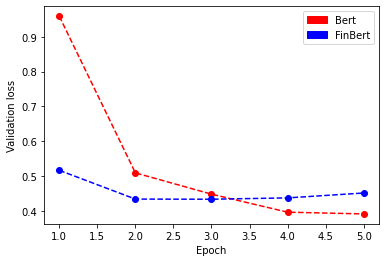

In [25]:
plt.plot(epoch, val_loss_bert, 'ro--')
plt.plot(epoch, val_loss_fin, 'bo--')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
colors = {'Bert':'red', 'FinBert':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.show()

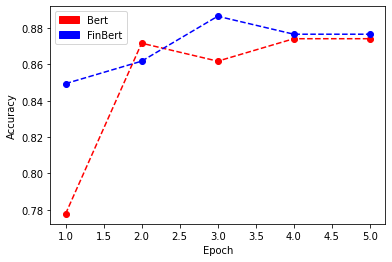

In [26]:
plt.plot(epoch, accuracy_bert, 'ro--')
plt.plot(epoch, accuracy_fin, 'bo--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
colors = {'Bert':'red', 'FinBert':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.show()

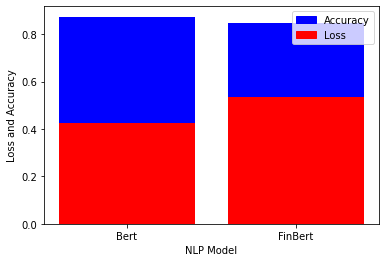

In [28]:
plt.bar(model, test_accuracy, color='blue')
plt.bar(model, test_loss, color='red')
plt.xlabel('NLP Model')
plt.ylabel('Loss and Accuracy')
colors = {'Accuracy':'blue', 'Loss':'red'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.show()